In [3]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16567, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 16567 (delta 23), reused 31 (delta 13), pack-reused 16522
Receiving objects: 100% (16567/16567), 15.07 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (11376/11376), done.
/Users/ashishparulekar/Deep-Learning/yolov5/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [4]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
     

Setup complete. Using torch 2.2.2 CPU


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="y6vIDctWghL3zD7GUzdD")
project = rf.workspace("deep-learning-hjjyq").project("object-detection-ohzub")
version = project.version(5)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Object-Detection-5 in yolov5pytorch:: 100%|█| 


In [6]:
%cd /Users/ashishparulekar/Deep-Learning/yolov5

/Users/ashishparulekar/Deep-Learning/yolov5


In [7]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- ball
- tshirt
- vaccum cleaner
nc: 3
roboflow:
  license: CC BY 4.0
  project: object-detection-ohzub
  url: https://universe.roboflow.com/deep-learning-hjjyq/object-detection-ohzub/dataset/5
  version: 5
  workspace: deep-learning-hjjyq
test: ../test/images
train: Object-Detection-5/train/images
val: Object-Detection-5/valid/images


In [8]:

# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:

#this is the model configuration we will use
%cat /Users/ashishparulekar/Deep-Learning/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [10]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [14]:
%%writetemplate /Users/ashishparulekar/Deep-Learning/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [15]:
# train yolov5s on custom data for 100 epochs
# time its performance
%cd /Users/ashishparulekar/Deep-Learning/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/Users/ashishparulekar/Deep-Learning/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/Users/ashishparulekar/Deep-Learning/yolov5/yolov5/Object-Detection-5/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 232 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.11.5 torch-2.2.2 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epoc

                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.341     0.0983    0.00875    0.00206

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       8/99         0G      0.078    0.03136     0.0342          6        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.348     0.0457    0.00806    0.00187

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       9/99         0G    0.07477     0.0314    0.03293          2        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74    0.00265      0.341    0.00841    0.00251

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      10/99         0G    0.07473    0.03031    0.03284          1        416: 1
          

      32/99         0G     0.0635    0.03407    0.02291          2        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.153      0.112     0.0701     0.0214

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      33/99         0G    0.06232    0.03281    0.02449          1        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.126      0.168     0.0657     0.0241

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      34/99         0G     0.0628     0.0328    0.02588          4        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.049      0.248     0.0477     0.0131

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      35/9

      57/99         0G    0.05217    0.02986    0.01911          2        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.204      0.428      0.214     0.0739

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      58/99         0G    0.05524    0.03385     0.0173         10        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.344      0.332      0.266     0.0726

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      59/99         0G    0.05407    0.03331    0.01631          9        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.143      0.406      0.176     0.0762

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      60/9

      82/99         0G    0.04819    0.02948    0.01284          1        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.433      0.434      0.434      0.156

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      83/99         0G    0.04636    0.02994    0.01165          3        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.343      0.594      0.453      0.178

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      84/99         0G    0.04638    0.02925    0.01193          1        416: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         39         74      0.475       0.45        0.4      0.159

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      85/9

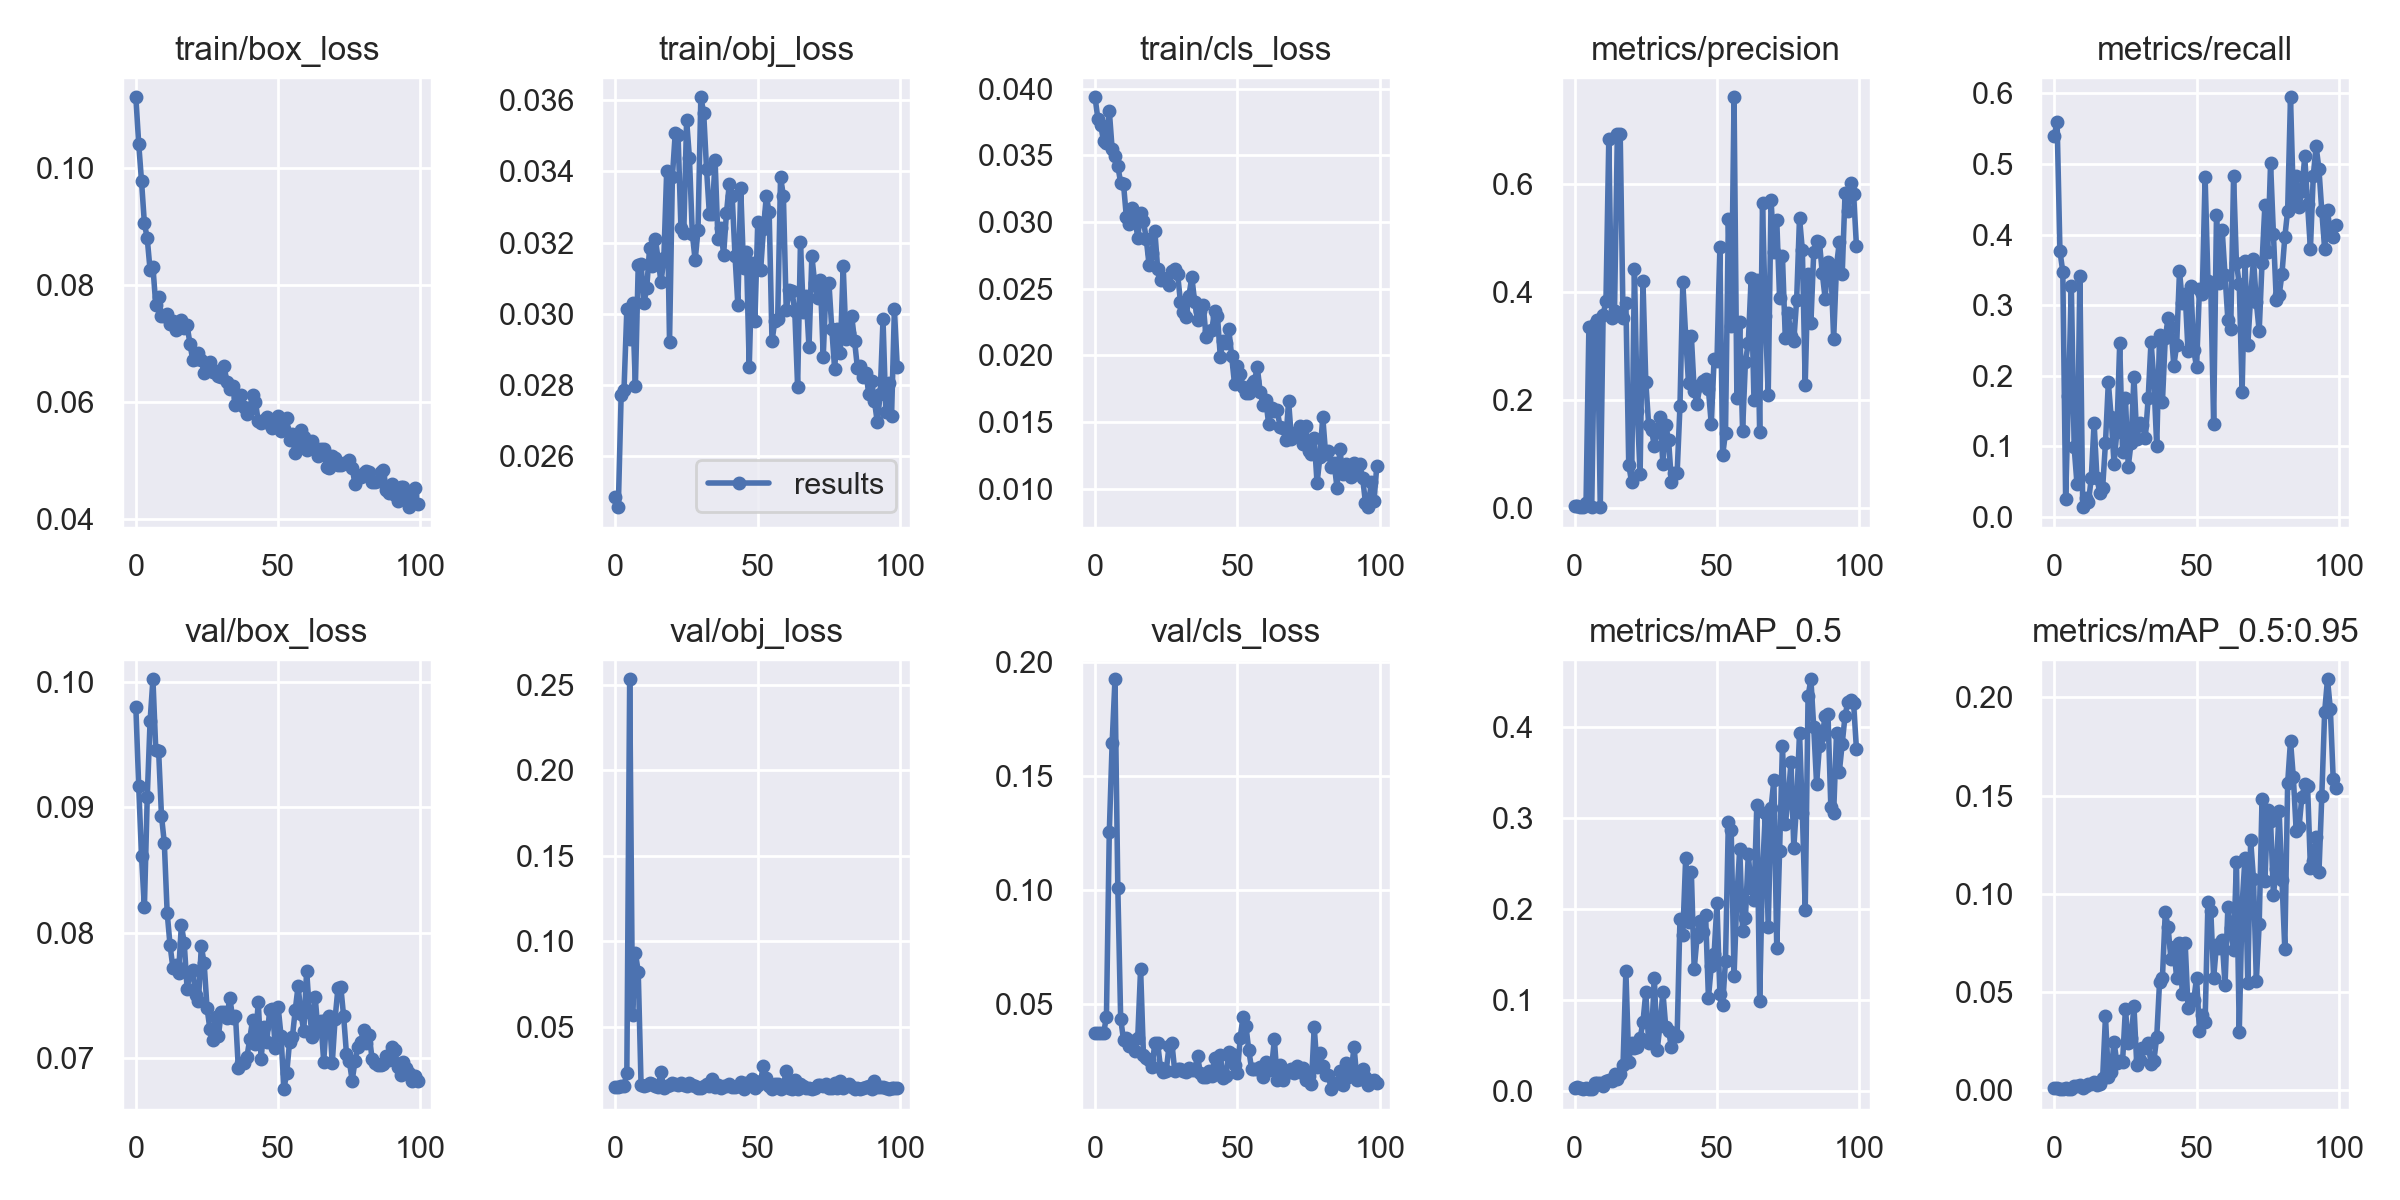

In [17]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/Users/ashishparulekar/Deep-Learning/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

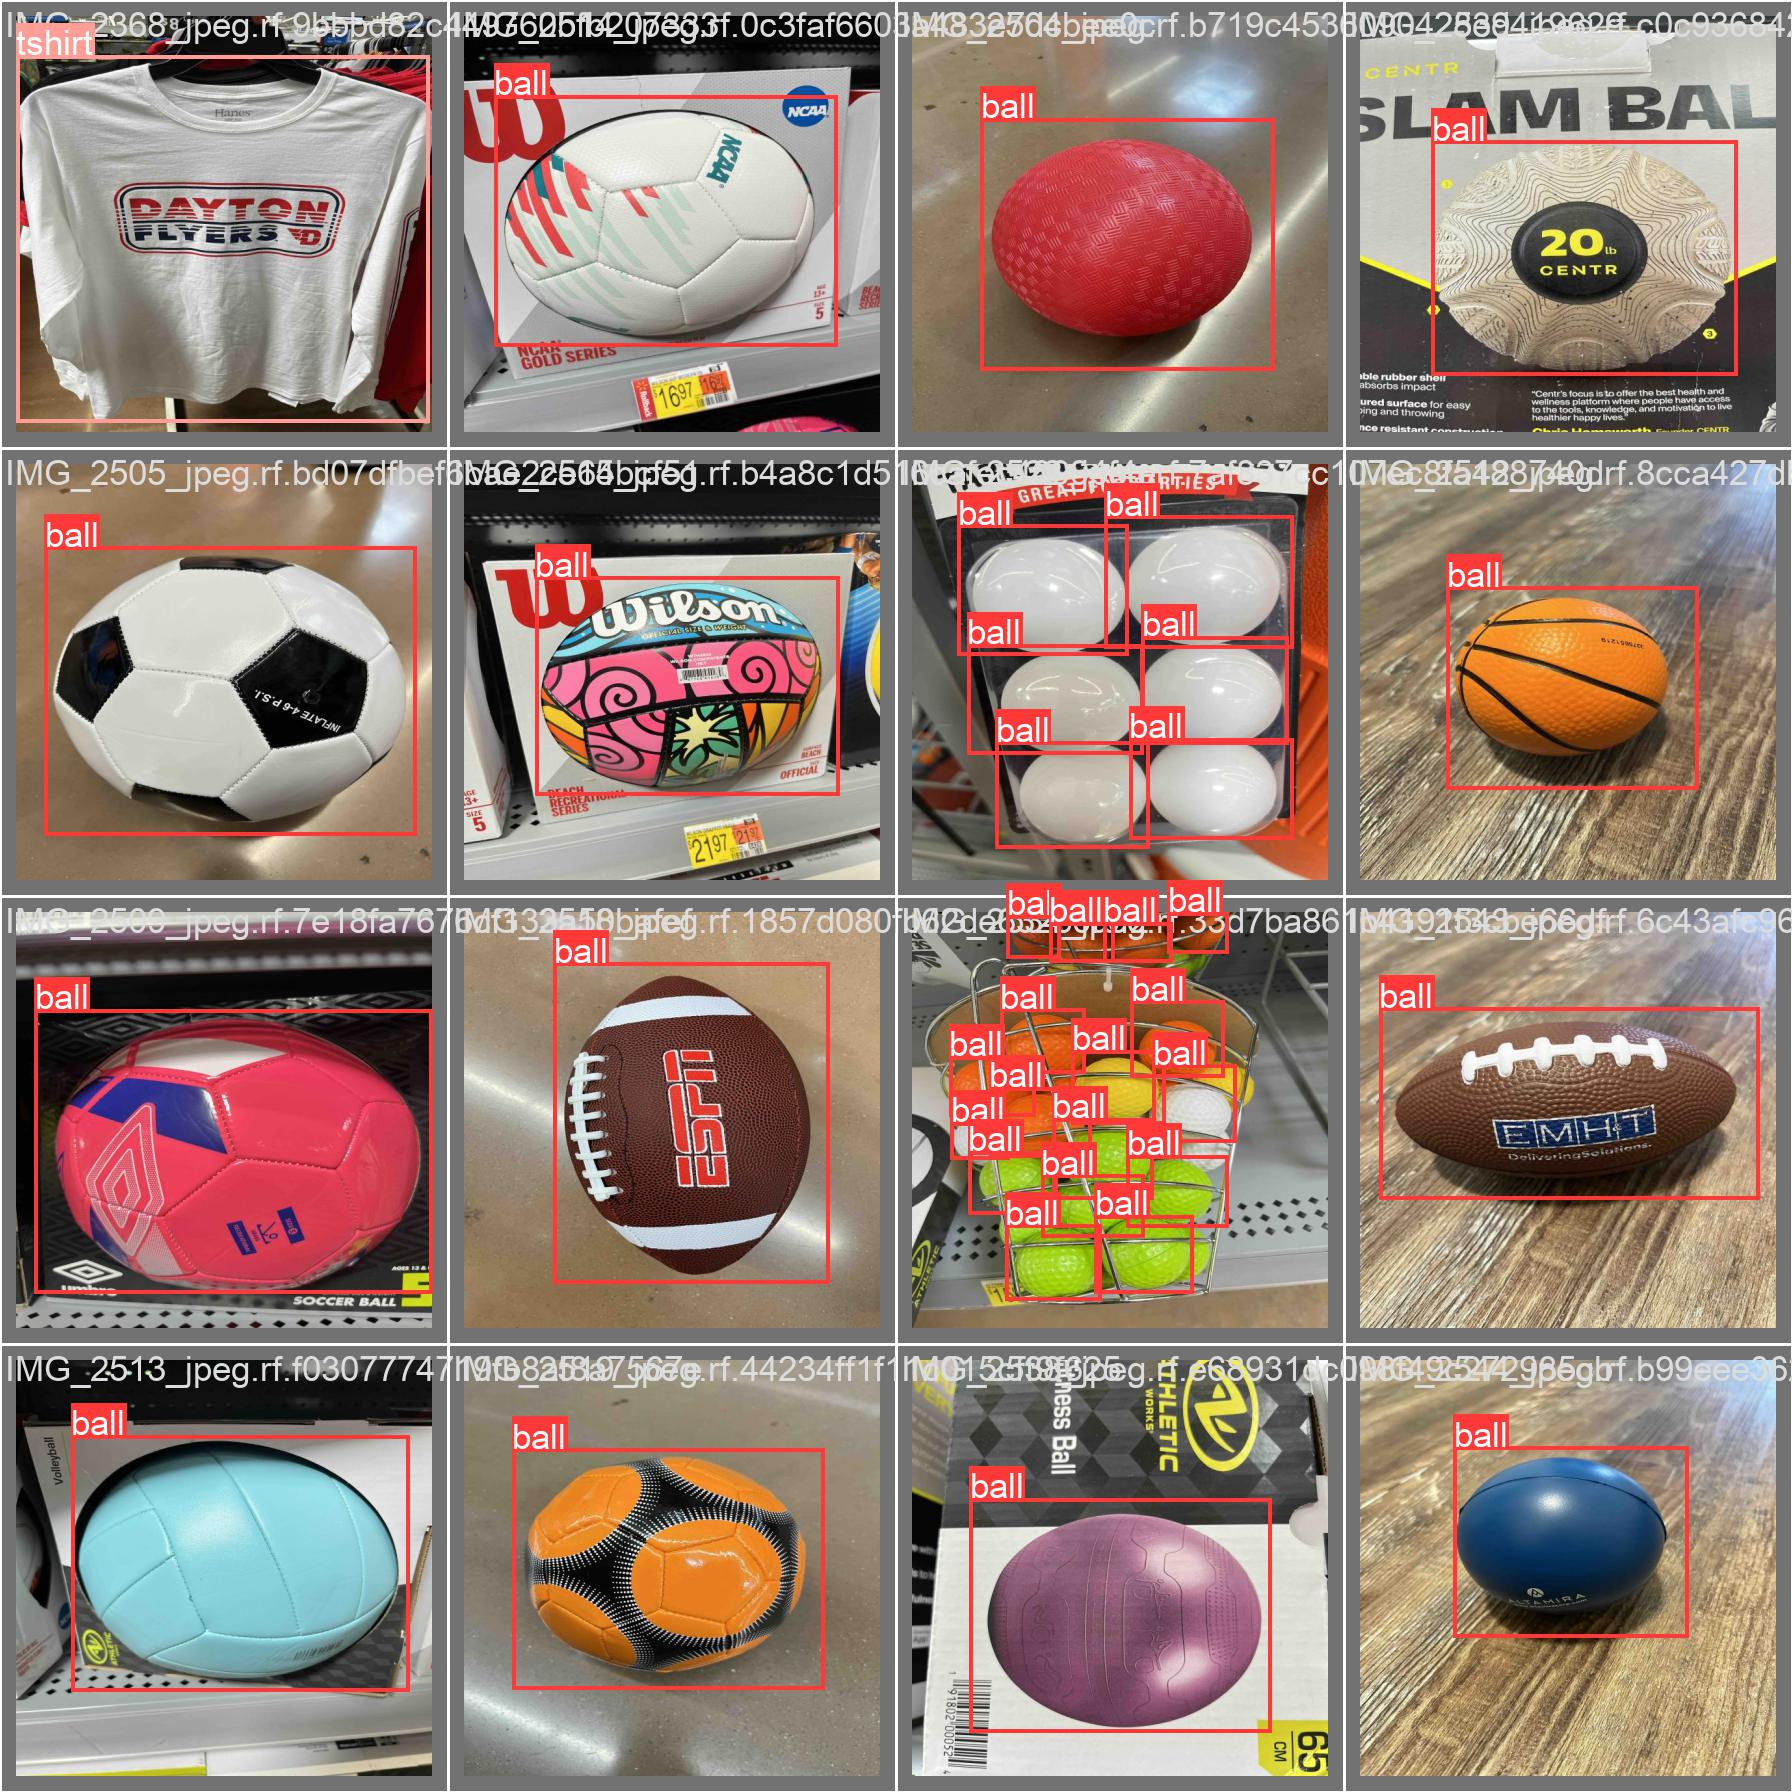

In [32]:
Image(filename='/Users/ashishparulekar/Deep-Learning/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


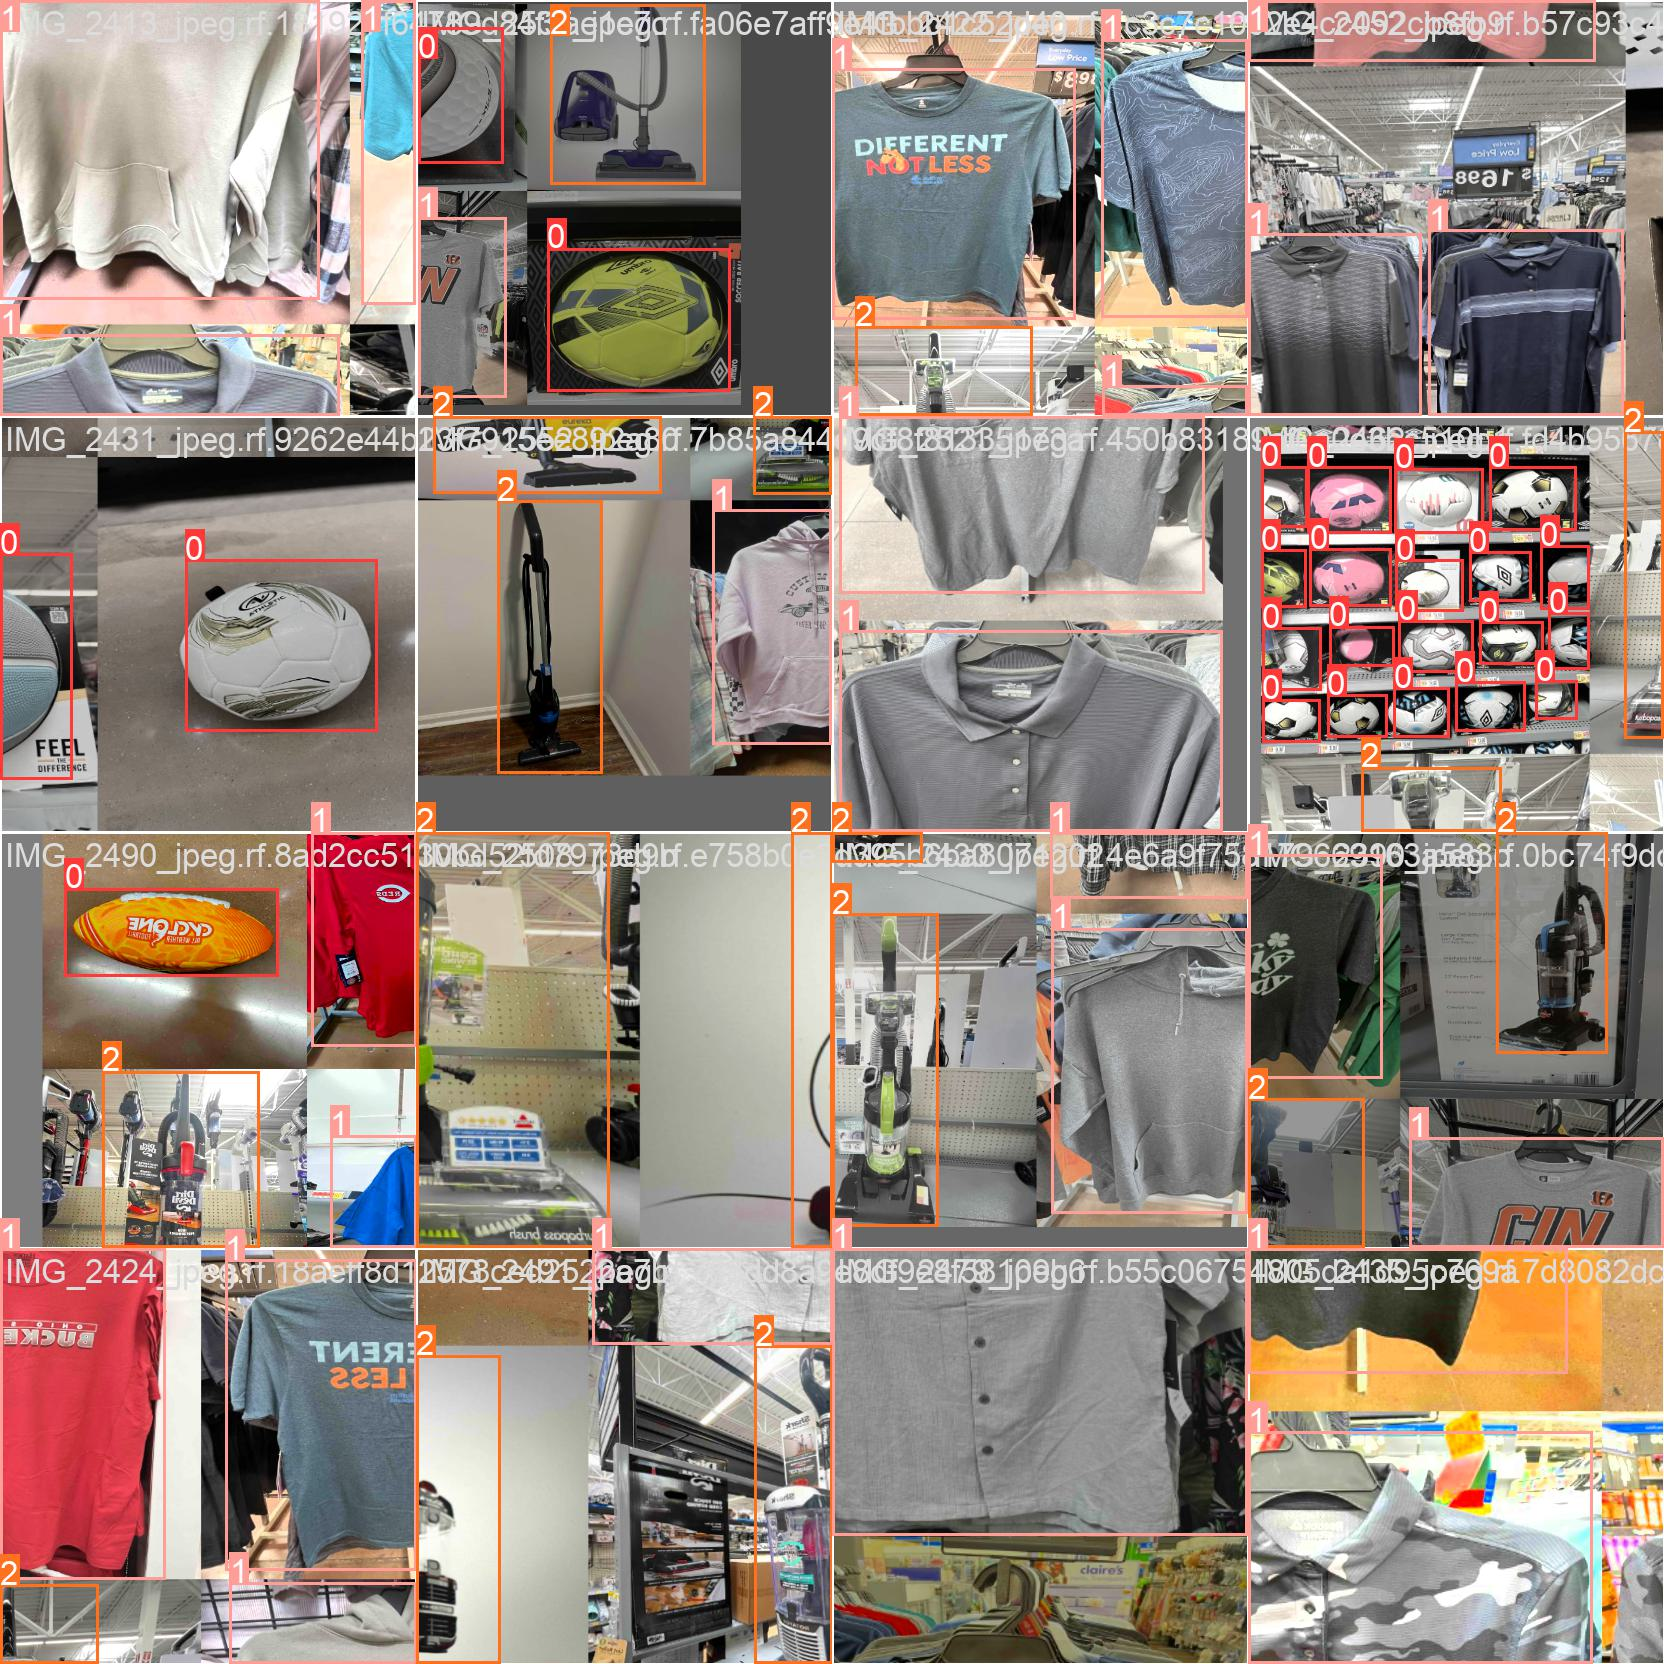

In [19]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/Users/ashishparulekar/Deep-Learning/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [20]:

# trained weights are saved by default in our weights folder
%ls runs/

train/


In [22]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [24]:
%cd /Users/ashishparulekar/Deep-Learning/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source Object-Detection-5/test/images/
     

/Users/ashishparulekar/Deep-Learning/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=Object-Detection-5/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.11.5 torch-2.2.2 CPU

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
image 1/20 /Users/ashishparulekar/Deep-Learning/yolov5/Object-Detection-5/test/images/IMG_2369_jpeg.rf.9d07469d1ab60358c88873afc694ee02.jpg: 416x416 1 tshirt, 66.5ms
image 2/20 /Users/ashishparulekar/Deep-Learning/yolov5/Object-Detection-5/test/images/IMG_2373_jpeg.rf.c74a85810cedcc8d7c4b2792aa13a32f.jpg: 416x416

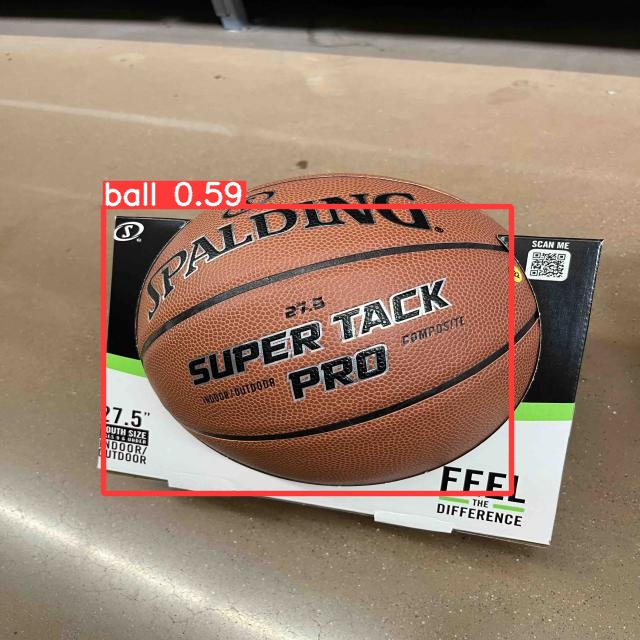

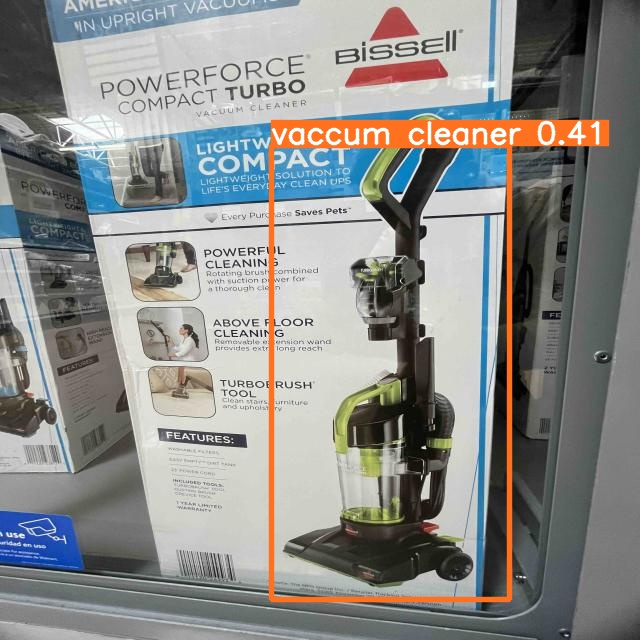

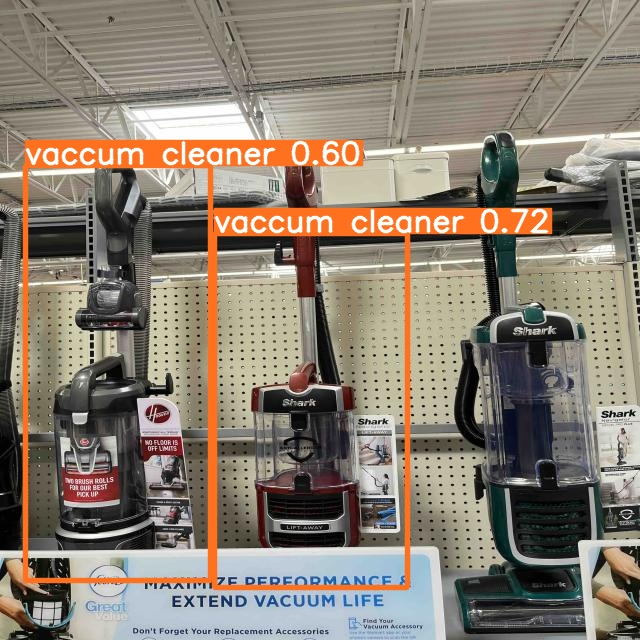

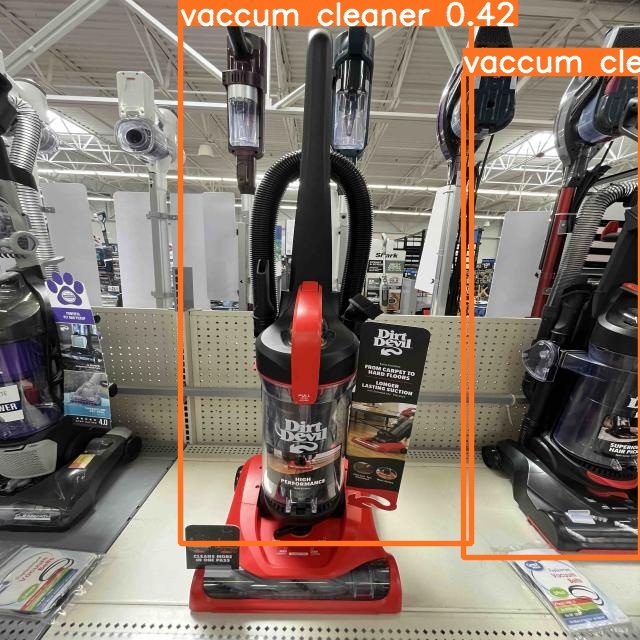

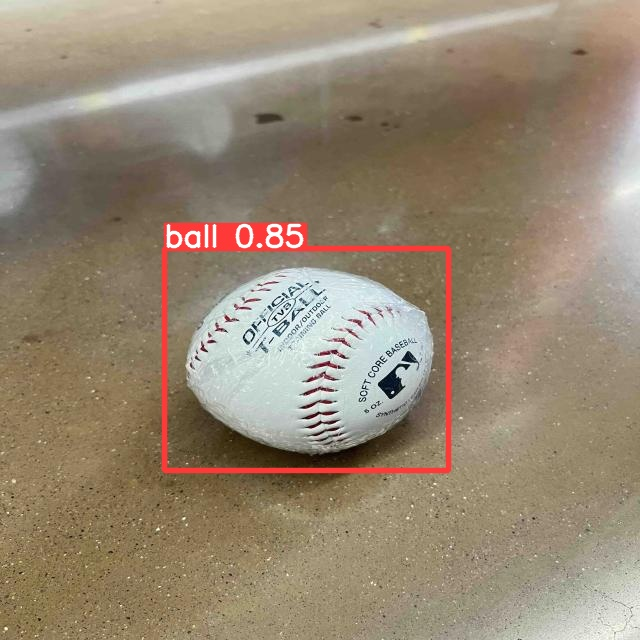

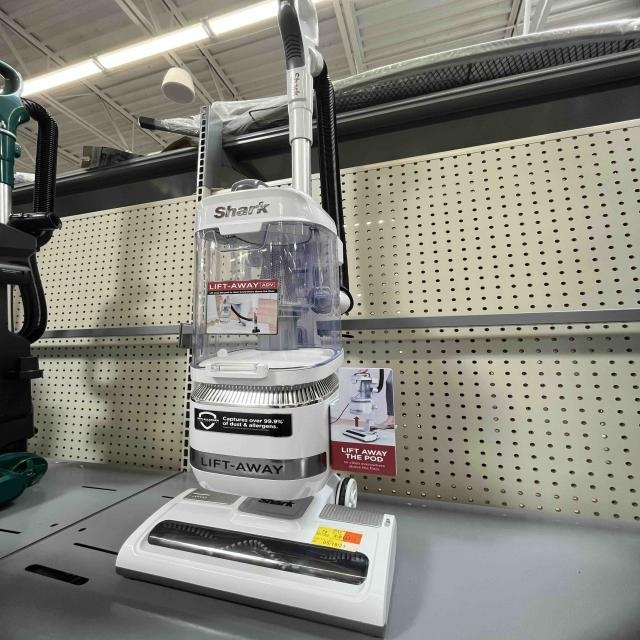

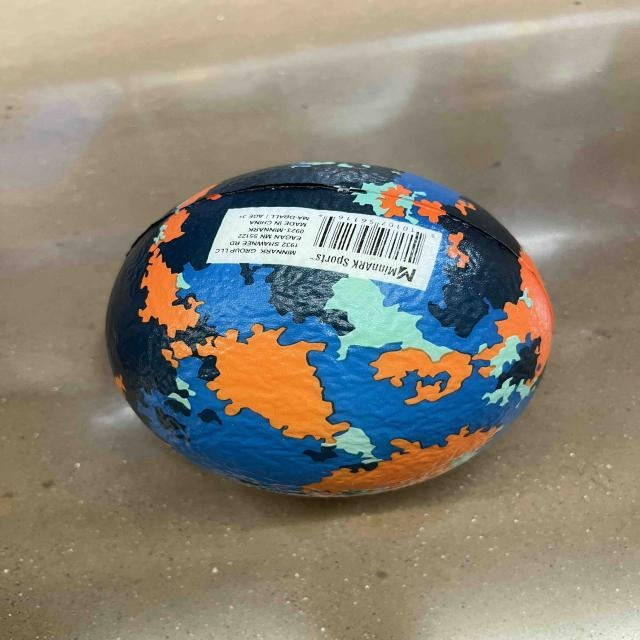

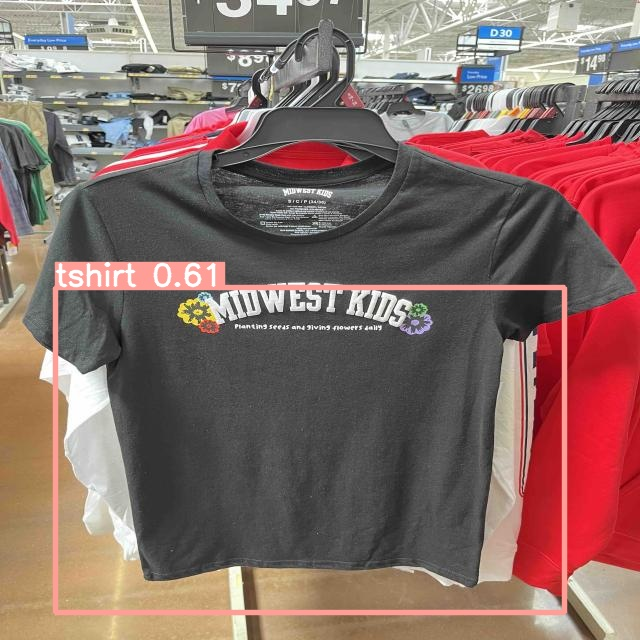

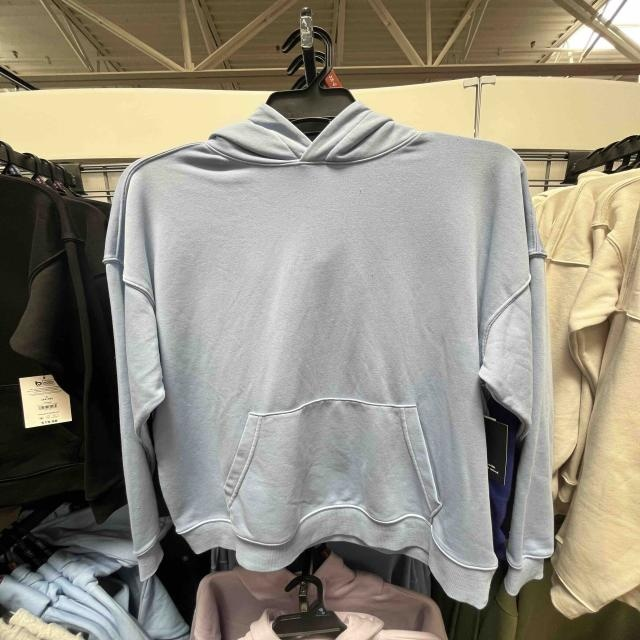

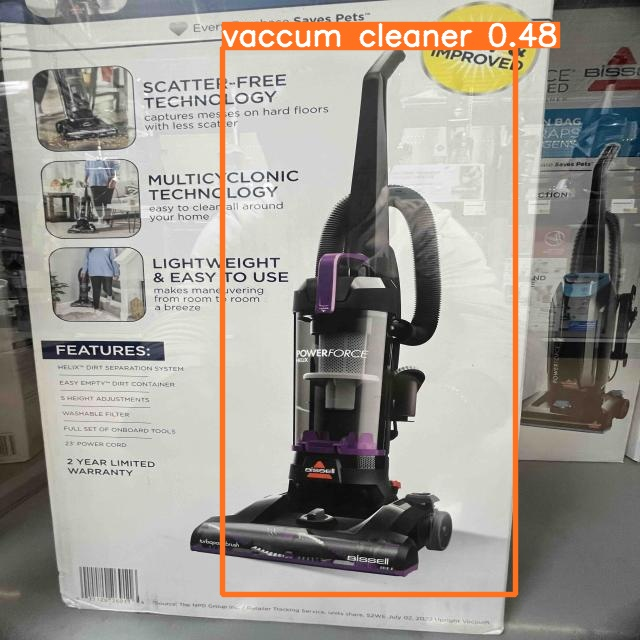

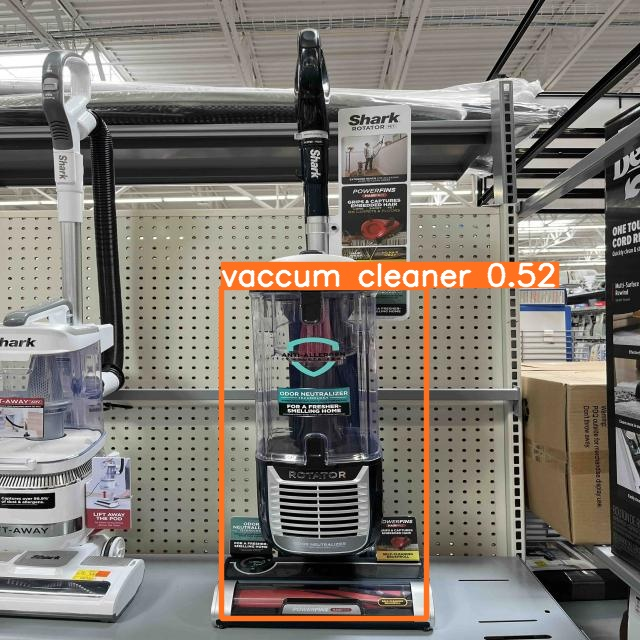

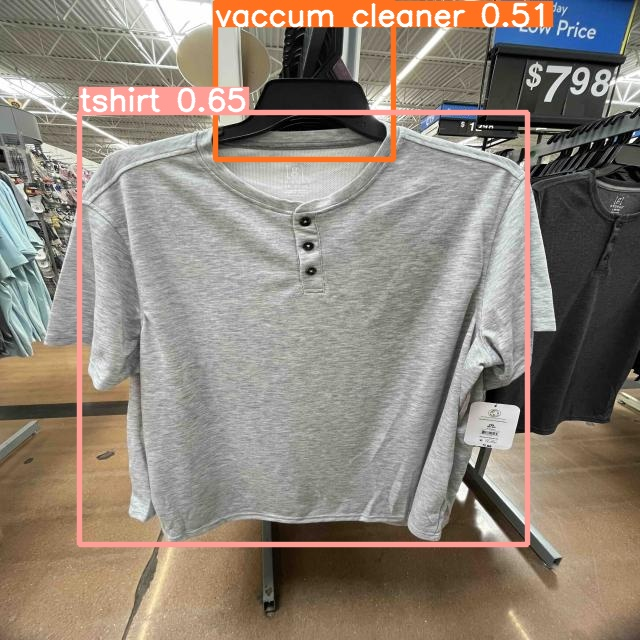

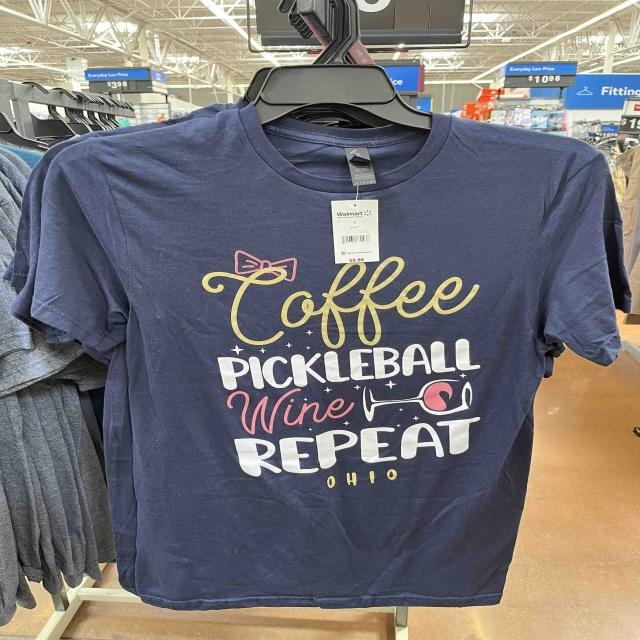

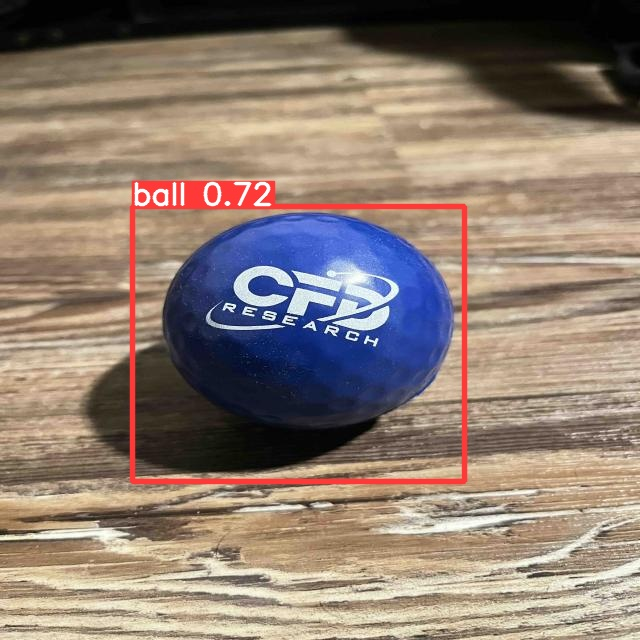

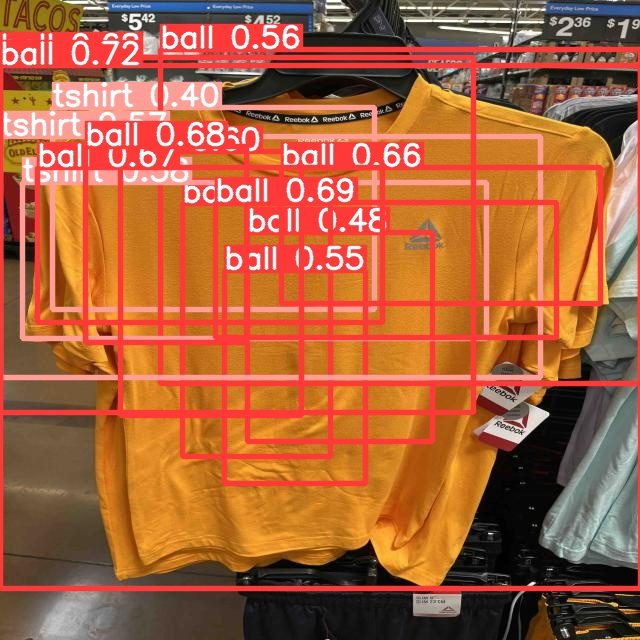

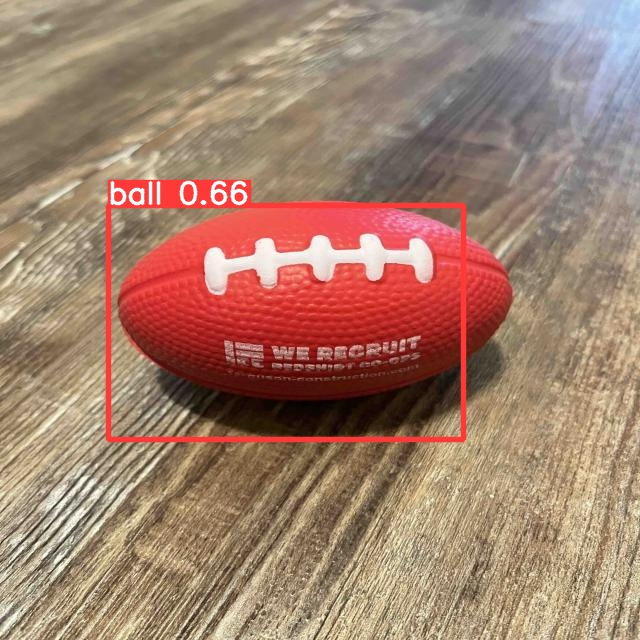

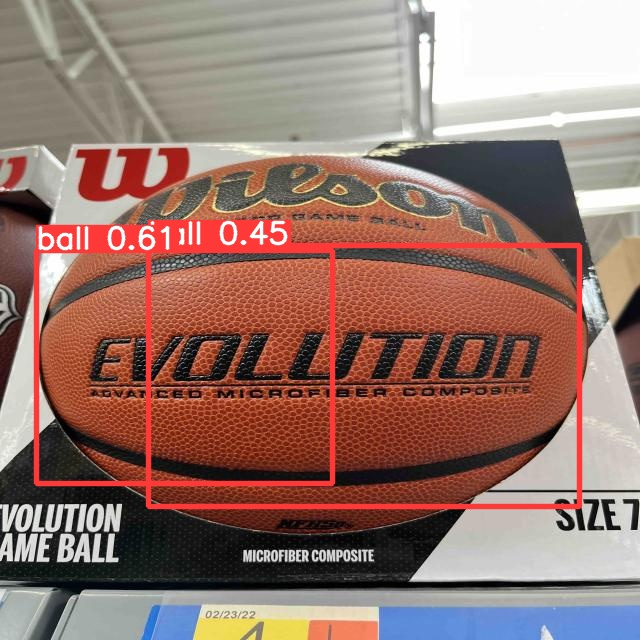

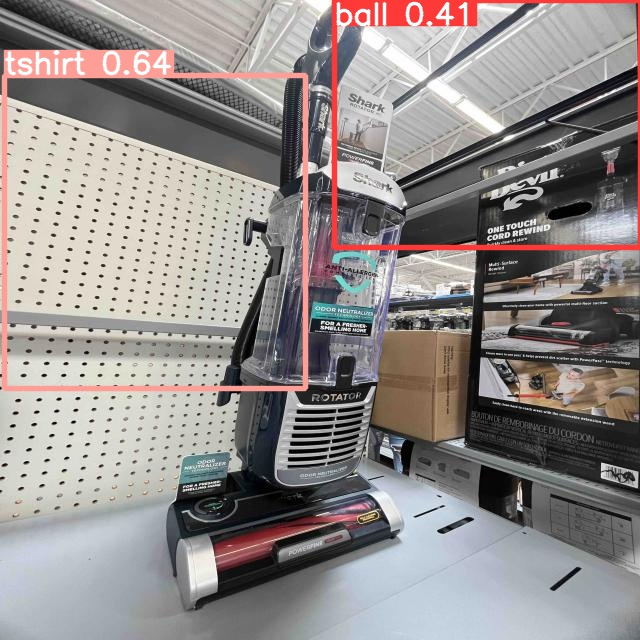

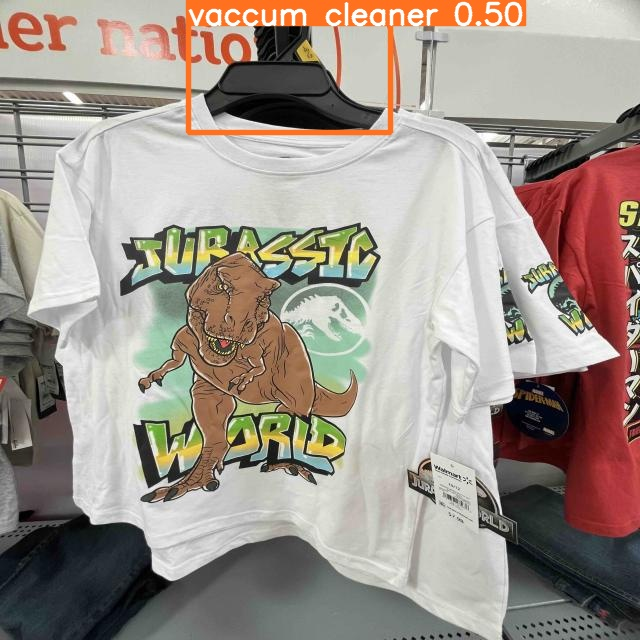

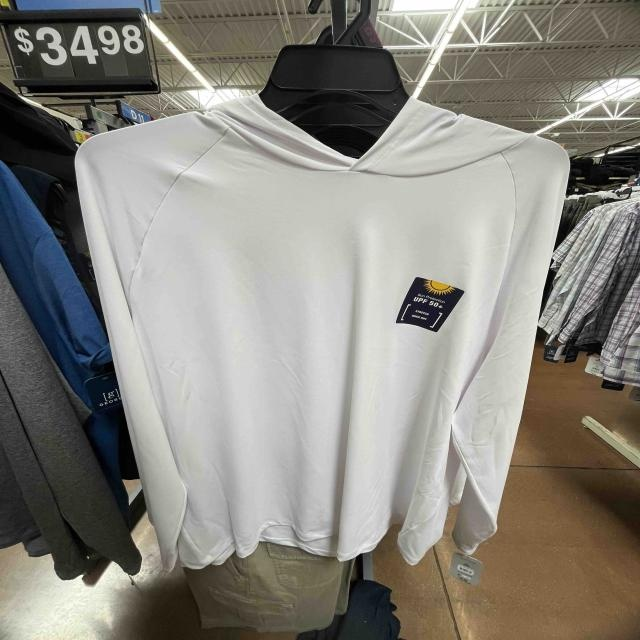

In [33]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/Users/ashishparulekar/Deep-Learning/yolov5/runs/detect/exp2/*.jpg')[:31]: #assuming JPG
    display(Image(filename=imageName))

In [28]:
rf = Roboflow(api_key="y6vIDctWghL3zD7GUzdD")
project = rf.workspace("deep-learning-hjjyq").project("object-detection-ohzub")
dataset = project.version(5)

project.version(dataset.version).deploy(model_type="yolov5", model_path=f"/Users/ashishparulekar/Deep-Learning/yolov5/runs/train/yolov5s_results/")

loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/deep-learning-hjjyq/object-detection-ohzub/5
Share your model with the world at: https://universe.roboflow.com/deep-learning-hjjyq/object-detection-ohzub/model/5


In [29]:

#Run inference on your model on a persistant, auto-scaling, cloud API

#load model
model = project.version(dataset.version).model

#choose random test set image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image, confidence=40, overlap=30).json()
pred

AttributeError: 'Version' object has no attribute 'location'